# Translate your own language

## Introduction

In [156]:
import torch, torchdata, torchtext
from torch import nn
import torch.nn.functional as F

import random, math, time

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#make our work comparable if restarted the kernel
SEED = 1234
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

cpu


In [157]:
# torch.cuda.get_device_name(0)

In [158]:
torch.__version__

'1.13.1'

In [159]:
torchtext.__version__

'0.14.1'

## 1. ETL: Loading the dataset

**Note**: Here I chose to translate English to German, simply it is easier for myself, since I don't understand German so it is difficult for me to imagine a sentence during inference.

In [160]:
import numpy as np
import sklearn
import pandas as pd

from sklearn.model_selection import train_test_split

df = pd.read_csv('/Users/sapnathapa/Documents/AIT/Spring Sem 2023/NLP/ENg_Dzo_Translation/Hindi_English_Truncated_Corpus.csv')
print(df.head())
print(df.shape)

      source                                   english_sentence  \
0        ted  politicians do not have permission to do what ...   
1        ted         I'd like to tell you about one such child,   
2  indic2012  This percentage is even greater than the perce...   
3        ted  what we really mean is that they're bad at not...   
4  indic2012  .The ending portion of these Vedas is called U...   

                                      hindi_sentence  
0  राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर...  
1  मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...  
2   यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।  
3     हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते  
4        इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।  
(127607, 3)


In [161]:
from torchtext.datasets import Multi30k

SRC_LANGUAGE = 'en'
TRG_LANGUAGE = 'hi'

## 2. EDA - simple investigation

In [162]:
en_data = df['english_sentence']
hi_data = df['hindi_sentence']

In [163]:
len(en_data), len(hi_data)

(127607, 127607)

In [164]:
data = [(data[0], data[1]) for data in zip(en_data, hi_data)]

In [165]:
data = data[:25000]

In [166]:
total_size = len(data)
total_size

25000

In [167]:
for en, hi in data:
  print(en, hi)
  break

politicians do not have permission to do what needs to be done. राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह करने कि अनुमति नहीं है .


In [168]:
for count, i in enumerate(data):
    print(i)
    if count == 5:
        break

('politicians do not have permission to do what needs to be done.', 'राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह करने कि अनुमति नहीं है .')
("I'd like to tell you about one such child,", 'मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहूंगी,')
('This percentage is even greater than the percentage in India.', 'यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।')
("what we really mean is that they're bad at not paying attention.", 'हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते')
('.The ending portion of these Vedas is called Upanishad.', 'इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।')
('The then Governor of Kashmir resisted transfer , but was finally reduced to subjection with the aid of British .', 'कश्मीर के तत्कालीन गवर्नर ने इस हस्तांतरण का विरोध किया था , लेकिन अंग्रेजों की सहायता से उनकी आवाज दबा दी गयी .')


In [169]:
random.shuffle(data)
train_size = int(total_size *0.8)
val_size = int(train_size*0.2)

test = data[train_size:]
train_dataset = data[:train_size]
val = train_dataset[:val_size]
train = train_dataset[val_size:]



In [170]:
train_size = len(list(iter(train)))
val_size = len(list(iter(val)))
test_size = len(list(iter(test)))
print(train_size, val_size, test_size)

16000 4000 5000


## 3. Preprocessing 

### Tokenizing

**Note**: the models must first be downloaded using the following on the command line: 
```
python3 -m spacy download en_core_web_sm
python3 -m spacy download de_core_news_sm
```

First, since we have two languages, let's create some constants to represent that.  Also, let's create two dicts: one for holding our tokenizers and one for holding all the vocabs with assigned numbers for each unique word

In [171]:
# Place-holders
token_transform = {}
vocab_transform = {}

In [172]:
from torchtext.data.utils import get_tokenizer

token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')
token_transform[TRG_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')


In [173]:
#example of tokenization of the english part
print("Sentence: ", train[0][1])
print("Tokenization: ", token_transform[TRG_LANGUAGE](train[0][1]))

Sentence:  साधारण भाषा मे मैथुन एक से अधिक काम-क्रियाओ को संबोधित करने के लिए प्रयोग किया जाता है।
Tokenization:  ['साधारण', 'भाषा', 'मे', 'मैथुन', 'एक', 'से', 'अधिक', 'काम-क्रियाओ', 'को', 'संबोधित', 'करने', 'के', 'लिए', 'प्रयोग', 'किया', 'जाता', 'है', '।']


A function to tokenize our input.

In [174]:
# helper function to yield list of tokens
# here data can be `train` or `val` or `test`
def yield_tokens(data, language):
    language_index = {SRC_LANGUAGE: 0, TRG_LANGUAGE: 1}

    for data_sample in data:
        yield token_transform[language](data_sample[language_index[language]]) #either first or second index


Before we tokenize, let's define some special symbols so our neural network understand the embeddings of these symbols, namely the unknown, the padding, the start of sentence, and end of sentence.

In [175]:
# Define special symbols and indices
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>']

### Text to integers (Numericalization)

Next we gonna create function (torchtext called vocabs) that turn these tokens into integers.  Here we use built in factory function <code>build_vocab_from_iterator</code> which accepts iterator that yield list or iterator of tokens.

In [176]:
from torchtext.vocab import build_vocab_from_iterator

for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    # Create torchtext's Vocab object 
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train, ln), 
                                                    min_freq=5,   #if not, everything will be treated as UNK
                                                    specials=special_symbols,
                                                    special_first=True) #indicates whether to insert symbols at the beginning or at the end                                            
# Set UNK_IDX as the default index. This index is returned when the token is not found. 
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary. 
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    vocab_transform[ln].set_default_index(UNK_IDX)

In [177]:
#see some example
vocab_transform[SRC_LANGUAGE](['here', 'is', 'a', 'unknownword', 'a'])

[170, 12, 11, 0, 11]

In [178]:
#we can reverse it....
mapping = vocab_transform[SRC_LANGUAGE].get_itos()

#print 1816, for example
mapping[1816]

'fighting'

In [179]:
#let's try unknown vocab
mapping[0]
#they will all map to <unk> which has 0 as integer

'<unk>'

In [180]:
#let's try special symbols
mapping[1], mapping[2], mapping[3]

('<pad>', '<sos>', '<eos>')

In [181]:
#check unique vocabularies
len(mapping)

5341

## 4. Preparing the dataloader

One thing we change here is the <code>collate_fn</code> which now also returns the length of sentence.  This is required for <code>packed_padded_sequence</code>

In [182]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

BATCH_SIZE = 64

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids):
    return torch.cat((torch.tensor([SOS_IDX]), 
                      torch.tensor(token_ids), 
                      torch.tensor([EOS_IDX])))

# src and trg language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TRG_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tesors
def collate_batch(batch):
    src_batch, src_len_batch, trg_batch = [], [], []
    for src_sample, trg_sample in batch:
        processed_text = text_transform[SRC_LANGUAGE](src_sample.rstrip("\n"))
        src_batch.append(processed_text)
        trg_batch.append(text_transform[TRG_LANGUAGE](trg_sample.rstrip("\n")))
        src_len_batch.append(processed_text.size(0))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    trg_batch = pad_sequence(trg_batch, padding_value=PAD_IDX)
    return src_batch, torch.tensor(src_len_batch, dtype=torch.int64), trg_batch

Create train, val, and test dataloaders

In [183]:
batch_size = 64

train_loader = DataLoader(train, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
valid_loader = DataLoader(val, batch_size=batch_size,
                              shuffle=True, collate_fn=collate_batch)
test_loader  = DataLoader(test, batch_size=batch_size,
                             shuffle=True, collate_fn=collate_batch)

Let's test the train loader.

In [184]:
for en, _, hi in train_loader:
    break

In [185]:

print("Hindi shape: ", hi.shape)  # (seq len, batch_size)
print("English shape: ", en.shape)

Hindi shape:  torch.Size([118, 64])
English shape:  torch.Size([81, 64])


## 5. Design the model

### Encoder

The changes here all within the forward method. It now accepts the lengths of the source sentences as well as the sentences themselves.

After the source sentence (padded automatically within the iterator) has been embedded, we can then use pack_padded_sequence on it with the lengths of the sentences. Note that the tensor containing the lengths of the sequences must be a CPU tensor as of the latest version of PyTorch, which we explicitly do so with to('cpu'). packed_embedded will then be our packed padded sequence. This can be then fed to our RNN as normal which will return packed_outputs, a packed tensor containing all of the hidden states from the sequence, and hidden which is simply the final hidden state from our sequence. hidden is a standard tensor and not packed in any way, the only difference is that as the input was a packed sequence, this tensor is from the final non-padded element in the sequence.

We then unpack our packed_outputs using pad_packed_sequence which returns the outputs and the lengths of each, which we don't need.

The first dimension of outputs is the padded sequence lengths however due to using a packed padded sequence the values of tensors when a padding token was the input will be all zeros.


In [186]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()

        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn       = nn.GRU(emb_dim, hid_dim, bidirectional=True)
        self.fc        = nn.Linear(hid_dim * 2, hid_dim)
        self.dropout   = nn.Dropout(dropout)
        
    def forward(self, src, src_len):
        
        #src: [src len, batch size]
        #src len: [batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, 
                            src_len.to('cpu'), enforce_sorted=False)
        
        #packed_outputs contain all hidden states including padding guy
        #hidden contains the last hidden states of the non-padded guys
        packed_outputs, hidden = self.rnn(packed_embedded)
        #hidden: [n layers * num directions, batch size, hid dim]
        
        #convert packed_outputs to the guy that does not contain hidden states for padding
        outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)
        #outputs: [src len, batch size, hid dim * num directions]
        
        #take the last hidden states from backward and forward
        #hidden: (f, b, f, b)
        forward  = hidden[-2, :, :]  #[batch size, hid dim]
        backward = hidden[-1, :, :]  #[batch size, hid dim]
        
        hidden = torch.tanh(self.fc(torch.cat((forward, backward), dim = 1))) 
        #hidden: [batch size, hid dim]
        
        return outputs, hidden
     

### Attention

Attention used here is additive attention which is defined by:

Previously, we allowed this module to "pay attention" to padding tokens within the source sentence. However, using masking, we can force the attention to only be over non-padding elements.

The forward method now takes a mask input. This is a [batch size, source sentence length] tensor that is 1 when the source sentence token is not a padding token, and 0 when it is a padding token. For example, if the source sentence is: ["hello", "how", "are", "you", "?",,], then the mask would be [1, 1, 1, 1, 1, 0, 0].

We apply the mask after the attention has been calculated, but before it has been normalized by the softmax function. It is applied using masked_fill. This fills the tensor at each element where the first argument (mask == 0) is true, with the value given by the second argument (-1e10). In other words, it will take the un-normalized attention values, and change the attention values over padded elements to be -1e10. As these numbers will be miniscule compared to the other values they will become zero when passed through the softmax layer, ensuring no attention is payed to padding tokens in the source sentence.



In [187]:
class Attention(nn.Module):
    def __init__(self, hid_dim, variants):
        super().__init__()
        self.variants = variants
        self.v = nn.Linear(hid_dim, 1, bias = False)
        self.W = nn.Linear(hid_dim,     hid_dim) #for decoder
        self.U = nn.Linear(hid_dim * 2, hid_dim) #for encoder outputs
                
    def forward(self, hidden, encoder_outputs, mask):
        
        #hidden = [batch size, hid dim]
        #encoder_outputs = [src len, batch size, hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]

        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #encoder_outputs = [batch size, src len, hid dim * 2]

        if self.variants == 'additive': #work
            #repeat decoder hidden state src_len times
            hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
            #hidden = [batch size, src len, hid dim]
            
            energy = torch.tanh(self.W(hidden) + self.U(encoder_outputs))
            #energy = [batch size, src len, hid dim]
            
            attention = self.v(energy).squeeze(2)
            #attention = [batch size, src len]
            
        elif self.variants == 'general': #work
            hidden = hidden.unsqueeze(1).repeat(1, 1, 2)
            #hidden = [batch size, 1, hid dim*2]
            #encoder_outputs = [batch size, hid dim * 2, src len]

            energy = torch.bmm(hidden, encoder_outputs.transpose(1, 2))
            attention = energy.squeeze(1)
            #attention = [batch size, src len]

        elif self.variants == 'multiplicative':
            wh = self.W(hidden).unsqueeze(1).repeat(1, 1, 2)
            #wh = [batch size, 1, hid dim*2]
            #encoder_outputs = [batch size, hid dim * 2, src len]

            energy = torch.bmm(wh, encoder_outputs.transpose(1, 2))
            attention = energy.squeeze(1)

        #use masked_fill_ if you want in-place
        attention = attention.masked_fill(mask, -1e10)
        #attention = [batch size, src len]
        return F.softmax(attention, dim = 1)
    

In [188]:
#example of masked_fill
#reall that 1 is pad_idx
x = torch.tensor([ [9, 1, 7, 2, 1, 1], [99, 1, 1, 0, 8, 9] ])

mask = (x == PAD_IDX)

x.masked_fill_(mask, -1e10)
print(x)

tensor([[           9, -10000000000,            7,            2, -10000000000,
         -10000000000],
        [          99, -10000000000, -10000000000,            0,            8,
                    9]])


### Decoder

The decoder only needs a few small changes. It needs to accept a mask over the source sentence and pass this to the attention module. As we want to view the values of attention during inference, we also return the attention tensor.

In [189]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout, attention):
        super().__init__()
        
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.gru = nn.GRU((hid_dim * 2) + emb_dim, hid_dim)
        self.fc = nn.Linear((hid_dim * 2) + hid_dim + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs, mask):
        
        #input = [batch size]
        #hidden = [batch size, hid dim]
        #encoder_outputs = [src len, batch size, hid dim * 2]
        #mask = [batch size, src len]
        
        input = input.unsqueeze(0)
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        #embedded = [1, batch size, emb dim]
        
        a = self.attention(hidden, encoder_outputs, mask)
        #a = [batch size, src len]

        a = a.unsqueeze(1)
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #encoder_outputs = [batch size, src len, hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs) #Ct
        #weighted = [batch size, 1, hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        #weighted = [1, batch size, hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim = 2)
        #rnn_input = [1, batch size, (hid dim * 2) + emb dim]
        
        output, hidden = self.gru(rnn_input, hidden.unsqueeze(0))
        #output = [seq len, batch size, dec hid dim * n directions]
        #hidden = [1, batch size, hid dim]
        assert (output == hidden).all()

        embedded = embedded.squeeze(0)
        output   = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        prediction = self.fc(torch.cat((output, weighted, embedded), dim = 1))
        #prediction = [batch size, output dim]
        
        return prediction, hidden.squeeze(0), a.squeeze(1)

#### Putting them together (become Seq2Seq!)

The overarching seq2seq model also needs a few changes for packed padded sequences, masking and inference.

We need to tell it what the indexes are for the pad token and also pass the source sentence lengths as input to the forward method.

We use the pad token index to create the masks, by creating a mask tensor that is 1 wherever the source sentence is not equal to the pad token. This is all done within the create_mask function.

The sequence lengths as needed to pass to the encoder to use packed padded sequences.

The attention at each time-step is stored in the attentions

In [190]:
class Seq2SeqPackedAttention(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device
        
    def create_mask(self, src):
        #src: [src len, batch size]
        
        mask = (src == self.src_pad_idx).permute(1, 0)
        #mask: [batch size, src len]
        #we need to permute to make the mask same shape as attention...
        return mask

        
    def forward(self, src, src_len, trg, teacher_forcing_ratio = 0.5):
        
        #src: [src len, batch size]
        #src len: [batch size]
        #trg: [trg len, batch size]
        
        batch_size = src.shape[1]
        trg_len    = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim #define in decoder
        
        #because decoder decodes each step....let's create a list that gonna append the result to this guy
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)
        
        #because decoder decodes each step....let's memorize the attention done in each step....
        attentions = torch.zeros(trg_len, batch_size, src.shape[0]).to(self.device)
        
        #let's start!!!
        #1. encoder
        encoder_outputs, hidden = self.encoder(src, src_len)
        #encoder_outputs: [src len, batch size, hid dim * num directions]
        #hidden: [batch size, hid dim]
        
        #set the first input to the decoder
        input_ = trg[0,:]  #basically 
        
        #create the mask for use in this step
        mask = self.create_mask(src)
        
        #2. for each of trg word
        for t in range(1, trg_len):

            #3. decode (hidden is always carry forward)
            output, hidden, attention = self.decoder(input_, hidden, encoder_outputs, mask)
            #output:   [batch size, output_dim]
            #hidden:   [batch size, hid_dim]
            #attention::[batch size, src len]  ==> how each of src token is important to input_ 
            
            #4. append the results to outputs and attentions
            outputs[t] = output
            attentions[t] = attention
            
            #5. get the result, using argmax
            top1 = output.argmax(1)  #find the maximum index of dimension 1, which is output_dim
            
            #6. based on the teacher forcing ratio, 
            teacher_force_or_not = random.random() < teacher_forcing_ratio
                    #if teacher forcing, next input is the next trg
                    #if no teacher forcing, the next input is the argmax guy...
            input_ = trg[t] if teacher_force_or_not else top1  #autoregressive
            
        return outputs, attentions

## 6. Training

We can now define our encoder and decoders. This model is significantly smaller than Transformers used in research today, but is able to be run on a single GPU quickly.

The paper does not mention which weight initialization scheme was used, however Xavier uniform seems to be common amongst Transformer models, so we use it here.

In [191]:

def initialize_weights(m):
    for name, param in m.named_parameters():
        if 'weight' in name:
            nn.init.normal_(param.data, mean=0, std=0.01)
        else:
            nn.init.constant_(param.data, 0)

In [193]:
input_dim   = len(vocab_transform[SRC_LANGUAGE])
output_dim  = len(vocab_transform[TRG_LANGUAGE])
emb_dim     = 256  
hid_dim     = 512  
dropout     = 0.5
SRC_PAD_IDX = PAD_IDX

attn = Attention(hid_dim, variants='general')
enc  = Encoder(input_dim,  emb_dim,  hid_dim, dropout)
dec  = Decoder(output_dim, emb_dim,  hid_dim, dropout, attn)

model = Seq2SeqPackedAttention(enc, dec, SRC_PAD_IDX, device).to(device)
model.apply(initialize_weights)

Seq2SeqPackedAttention(
  (encoder): Encoder(
    (embedding): Embedding(5341, 256)
    (rnn): GRU(256, 512, bidirectional=True)
    (fc): Linear(in_features=1024, out_features=512, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (attention): Attention(
      (v): Linear(in_features=512, out_features=1, bias=False)
      (W): Linear(in_features=512, out_features=512, bias=True)
      (U): Linear(in_features=1024, out_features=512, bias=True)
    )
    (embedding): Embedding(5409, 256)
    (gru): GRU(1280, 512)
    (fc): Linear(in_features=1792, out_features=5409, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [194]:
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')
    
count_parameters(model)
     

1367296
393216
786432
  1536
  1536
393216
786432
  1536
  1536
524288
   512
   512
262144
   512
524288
   512
1384704
1966080
786432
  1536
  1536
9692928
  5409
______
18884129


In [195]:
import torch.optim as optim

lr = 0.001

#training hyperparameters
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX) 

In [196]:
def train(model, loader, optimizer, criterion, clip, loader_length):
    
    model.train()
    epoch_loss = 0
    
    for src, src_length, trg in loader:
        
        src = src.to(device)
        trg = trg.to(device)
        
        optimizer.zero_grad()
        
        output, attentions = model(src, src_length, trg)
        
        #trg    = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        output_dim = output.shape[-1]
        
        #the loss function only works on 2d inputs with 1d targets thus we need to flatten each of them
        output = output[1:].view(-1, output_dim)
        trg    = trg[1:].view(-1)
        #trg    = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        #clip the gradients to prevent them from exploding (a common issue in RNNs)
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / loader_length

In [197]:
def evaluate(model, loader, criterion, loader_length):
        
    #turn off dropout (and batch norm if used)
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for src, src_length, trg in loader:
        
            src = src.to(device)
            trg = trg.to(device)

            output, attentions = model(src, src_length, trg, 0) #turn off teacher forcing

            #trg    = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg    = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            
            epoch_loss += loss.item()
        
    return epoch_loss / loader_length
     

### Putting everything together

Finally, we train our actual model. This model is almost 3x faster than the convolutional sequence-to-sequence model and also achieves a lower validation perplexity!

**Note: similar to CNN, this model always has a teacher forcing ratio of 1, i.e. it will always use the ground truth next token from the target sequence (this is simply because CNN do everything in parallel so we cannot have the next token). This means we cannot compare perplexity values against the previous models when they are using a teacher forcing ratio that is not 1. To understand this, try run previous tutorials with teaching forcing ratio of 1, you will get very low perplexity.  **   

In [198]:
train_loader_length = len(train_loader)
val_loader_length   = len(valid_loader)
test_loader_length  = len(test_loader)

In [199]:
train_loader_length, val_loader_length, test_loader_length

(250, 63, 79)

In [200]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs
     

In [201]:
best_valid_loss = float('inf')
num_epochs = 5
clip       = 1

save_path = f'{model.__class__.__name__}.pt'

train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    
    start_time = time.time()

    train_loss = train(model, train_loader, optimizer, criterion, clip, train_loader_length)
    valid_loss = evaluate(model, valid_loader, criterion, val_loader_length)
    
    #for plotting
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    
    #lower perplexity is better

Epoch: 01 | Time: 26m 8s
	Train Loss: 5.953 | Train PPL: 384.797
	 Val. Loss: 5.703 |  Val. PPL: 299.619
Epoch: 02 | Time: 28m 20s
	Train Loss: 5.380 | Train PPL: 217.014
	 Val. Loss: 5.592 |  Val. PPL: 268.174
Epoch: 03 | Time: 28m 19s
	Train Loss: 5.120 | Train PPL: 167.347
	 Val. Loss: 5.507 |  Val. PPL: 246.456
Epoch: 04 | Time: 32m 1s
	Train Loss: 4.908 | Train PPL: 135.312
	 Val. Loss: 5.411 |  Val. PPL: 223.832
Epoch: 05 | Time: 30m 51s
	Train Loss: 4.676 | Train PPL: 107.362
	 Val. Loss: 5.360 |  Val. PPL: 212.665


Text(0, 0.5, 'loss')

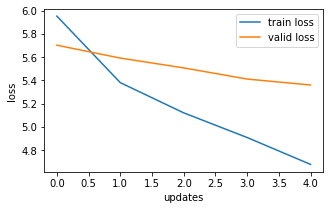

In [202]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(5, 3))
ax = fig.add_subplot(1, 1, 1)
ax.plot(train_losses, label = 'train loss')
ax.plot(valid_losses, label = 'valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss')

In [203]:
model.load_state_dict(torch.load(save_path))
test_loss = evaluate(model, test_loader, criterion, test_loader_length)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 5.341 | Test PPL: 208.635 |


## 7. Test on some random news

In [204]:
src_text = text_transform[SRC_LANGUAGE](data[3][0]).to(device)
trg_text = text_transform[TRG_LANGUAGE](data[3][1]).to(device)
src_text, trg_text

(tensor([   2,    8,  180,  141,   18,   10,    4,  432,  162, 1838,    6,   80,
         3309,   24,  172,    5,    3]),
 tensor([   2,   10,  915,  222, 1674,    6,   88,  112,    6,    0,    9,   33,
            0,    0,    0,    7,    3]))

In [205]:
src_text = src_text.reshape(-1, 1)  #because batch_size is 1
trg_text = trg_text.reshape(-1, 1)
src_text.shape, trg_text.shape

(torch.Size([17, 1]), torch.Size([17, 1]))

In [206]:
text_length = torch.tensor([src_text.size(0)]).to(dtype=torch.int64)

In [208]:
model.load_state_dict(torch.load(save_path))

model.eval()
with torch.no_grad():
    output, attentions = model(src_text, text_length, trg_text) #turn off teacher forcing

In [209]:

output = output.squeeze(1)
output = output[1:]
output.shape

torch.Size([16, 5409])

In [210]:
output_max = output.argmax(1) #returns max indices

In [211]:
output_max

tensor([10,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  7,  3])

In [212]:
mapping = vocab_transform[TRG_LANGUAGE].get_itos()

In [213]:
for token in output_max:
    print(mapping[token.item()])

और
<unk>
<unk>
<unk>
<unk>
<unk>
<unk>
<unk>
<unk>
<unk>
<unk>
<unk>
<unk>
<unk>
.
<eos>


In [214]:
data[10]

('They had never been asked these strange questions .',
 'वे भोचक़्के-से थे.ये अजीबो-गरीब सवाल उनसे पहले कभी नहीं किये गये थे .')